This notebook explores the PHAT v2 artificial star test (AST) results, and how to use them in `m31hst`.

In [1]:
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
from astroML.stats import binned_statistic
import matplotlib.pyplot as plt

Assuming that the Williams et al 2014 Table 6 file was downloaded to the correct location (see the README of [m31hst](http://github.com/jonathansick/m31hst)), the AST result catalog can be loaded with the `load_phat_ast_table` into an astropy table.

In [2]:
from m31hst.phatast import load_phat_ast_table
t = load_phat_ast_table()

PHAT did AST work in six fields, but unfortunately they don't label what field a star belongs to. This labelling is important because it connects the AST results to measurements of local stellar density. Here I'm showing that we can use K-Means clustering on the stars to reliably label stars into the six AST fields.

In [3]:
km = KMeans(n_clusters=6)
xy = np.vstack((t['ra'], t['dec'])).T
km.fit(xy)
centers = km.cluster_centers_
print centers

[[ 10.68679924  41.30852815]
 [ 11.55581084  42.14674574]
 [ 11.15978774  41.63931688]
 [ 10.87125638  41.45011536]
 [ 10.80073952  41.31165493]
 [ 10.70681719  41.26110849]]


/Users/jsick/.virtualenvs/androphot/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


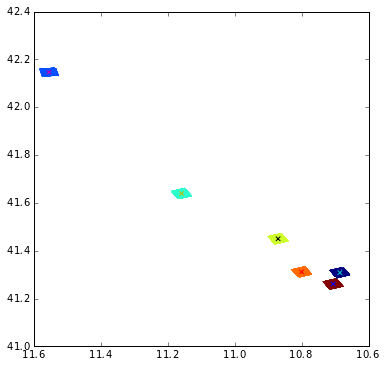

In [4]:
colors = ['c', 'm', 'y', 'k', 'r', 'b']

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(111)
ax.scatter(t['ra'], t['dec'],
           marker='.', edgecolors='None', s=1,
           c=km.labels_, rasterized=True)
ax.scatter(centers[:, 0], centers[:, 1],
           marker='x', s=20, c='None',
           edgecolors=colors, zorder=10)
ax.set_xlim(11.6, 10.6)
figure.show()

For each AST field, let's plot the median photometric error in the F475W band as a function of luminosity:

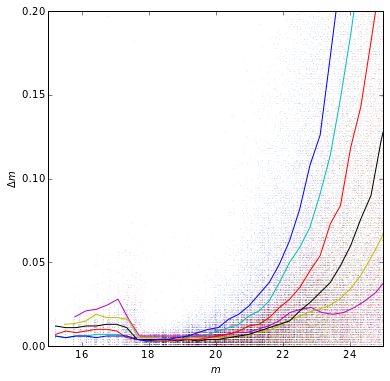

In [5]:
f2 = plt.figure(figsize=(6, 6))
ax = f2.add_subplot(111)
for label, c in zip(range(6), colors):
    sel = np.where(km.labels_ == label)[0]
    tt = t[sel]
    diffs = np.abs(tt['f475w_in'] - tt['f475w_out'])
    s = np.where(diffs < 10.)[0]
    err, edges = binned_statistic(tt['f475w_in'][s],
                                  diffs[s],
                                  statistic='median', bins=50)
    ax.scatter(tt['f475w_in'][::2], diffs[::2],
               s=1, marker='.', alpha=0.4,
               edgecolors='None', facecolors=c)
    ax.plot(edges[:-1], err, ls='-', c=c)
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$\Delta m$')
ax.set_ylim(0, 0.2)
ax.set_xlim(15., 25.)
f2.show()
        

We can also plot the completeness (fraction of artificial stars recovered successfully) in the F475W band as a function of luminosity for each AST field:

/Users/jsick/.virtualenvs/androphot/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide


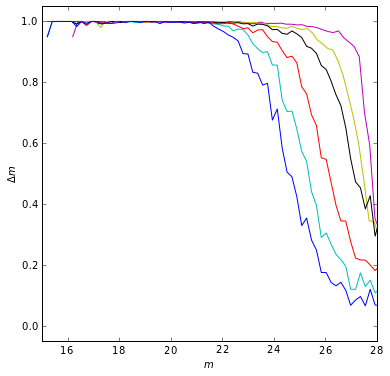

In [6]:
f3 = plt.figure(figsize=(6, 6))
ax = f3.add_subplot(111)
n_bins = 80
for label, c in zip(range(6), colors):
    sel = np.where(km.labels_ == label)[0]
    tt = t[sel]
    dropped = np.where(tt['f475w_out'] >= 90.)[0]
    drop_flag = np.ones(len(tt), dtype=np.float)
    drop_flag[dropped] = 0.
    total_recovered, edges = binned_statistic(tt['f475w_in'],
                                              drop_flag,
                                              statistic='sum',
                                              bins=n_bins)
                                              # range=np.array([15., 28.]))
    count, edges = binned_statistic(tt['f475w_in'],
                                    drop_flag,
                                    statistic='count',
                                    bins=n_bins)
                                    # range=np.array([15., 28.]))
    ax.plot(edges[:-1], total_recovered / count, ls='-', c=c)
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$\Delta m$')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(15., 28.)
f3.show()

We provide a `PhatAstTable` object to provide access to the AST data, sorted by field:

In [7]:
from m31hst.phatast import PhatAstTable
tbl = PhatAstTable()
tbl.fields

[{'center': [11.55581084, 42.14674574], 'label': 2},
 {'center': [11.15978774, 41.63931688], 'label': 0},
 {'center': [10.87125638, 41.45011536], 'label': 3},
 {'center': [10.80073952, 41.31165493], 'label': 4},
 {'center': [10.70681719, 41.26110849], 'label': 5},
 {'center': [10.68679924, 41.30852815], 'label': 1}]

Here we create a crowding file for use in StarFISH from stars in the outer-most (`0`) AST field:

In [8]:
tbl.write_crowdfile_for_field("crowdfile.txt", 0)

In [9]:
%%bash
head crowdfile.txt

11.52733764 42.13372135 31.86 +9.99 29.18 +9.99 27.36 +9.99 24.92 +9.99 100.00 +0.00 100.00 +0.00
11.52745046 42.13377440 18.98 -0.01 18.78 -0.01 19.23 -0.00 18.52 -0.01 100.00 +0.00 100.00 +0.00
11.52751654 42.13418871 32.18 +9.99 28.63 +9.99 26.19 -0.15 23.57 -0.03 100.00 +0.00 100.00 +0.00
11.52759235 42.13409927 23.42 -0.17 21.80 -0.04 20.70 -0.01 19.22 -0.01 100.00 +0.00 100.00 +0.00
11.52763084 42.13474965 34.40 +9.99 31.56 +9.99 29.24 +9.99 26.16 +9.99 100.00 +0.00 100.00 +0.00
11.52763255 42.13428584 19.14 -0.02 19.39 -0.01 20.24 -0.01 20.33 -0.01 100.00 +0.00 100.00 +0.00
11.52765099 42.13446225 32.22 +9.99 30.32 +9.99 28.77 +9.99 26.00 -0.19 100.00 +0.00 100.00 +0.00
11.52767011 42.13393800 31.22 +9.99 32.23 +9.99 27.20 +0.09 21.96 -0.02 100.00 +0.00 100.00 +0.00
11.52767600 42.13412654 23.12 -0.18 22.84 -0.08 23.03 -0.04 22.24 -0.02 100.00 +0.00 100.00 +0.00
11.52769302 42.13469713 23.11 -0.05 21.41 -0.01 19.27 -0.00 17.07 -0.01 100.00 +0.00 100.00 +0.00
